# Urn Task

This notebook tests whether a model behaves like a Bayesian observer on a two-urn sequential inference task.

In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_act_name

import circuitsvis as cv
from IPython.display import display

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

try:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception:
    pass

Seeds set to 42


In [ ]:
# huggingface login
from huggingface_hub import login

# login()

import os
hf_token = os.getenv('HF_TOKEN', None)
if hf_token:
    login(token=hf_token)
    print('Logged in to Hugging Face')
else:
    print('HF_TOKEN not set.')

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Logged in to Hugging Face


In [ ]:
# global config

# MODEL_ID = 'meta-llama/Llama-3.2-3B'
MODEL_ID = "attn-only-3l"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float16 if DEVICE == 'cuda' else torch.float32

# core urn parameters (used everywhere)
urn_A_pX = 0.6
urn_B_pX = 0.4
prior_P_A = 0.5

# prompt template (natural language)
# v0: shortest / least mathy
# v1-v3: longer paraphrases
prompt_template_version = 'v1'  # v0 | v1 | v2 | v3

# Forced-choice readout tokens (direct X/Y)
# We read out X vs Y directly to avoid A/B formatting bias.
ANSWER_TOKEN_A = ' X'
ANSWER_TOKEN_B = ' Y'
ANSWER_MEANS = {'A': 'X', 'B': 'Y'}

# Output directory
output_dir = 'results_urn_task'
os.makedirs(output_dir, exist_ok=True)

print('MODEL_ID:', MODEL_ID)
print('DEVICE:', DEVICE, 'DTYPE:', DTYPE)
print('Task: A_pX=%.2f B_pX=%.2f prior=%.2f' % (urn_A_pX, urn_B_pX, prior_P_A))
print('Prompt template:', prompt_template_version)
print('Output dir:', output_dir)

MODEL_ID: attn-only-3l
DEVICE: cuda DTYPE: torch.float16
Task: A_pX=0.60 B_pX=0.40 prior=0.50
Prompt template: v1
Output dir: results_urn_task


In [ ]:
# load model with TransformerLens

model = HookedTransformer.from_pretrained(MODEL_ID, device=DEVICE, dtype=DTYPE)
model.eval()

print('Loaded', MODEL_ID)
print('n_layers:', model.cfg.n_layers, 'n_heads:', model.cfg.n_heads, 'd_model:', model.cfg.d_model)
print('tokenizer:', type(model.tokenizer))

Loaded pretrained model attn-only-3l into HookedTransformer
Loaded attn-only-3l
n_layers: 3 n_heads: 8 d_model: 512
tokenizer: <class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>


In [ ]:
# tokenization sanity checks

def assert_single_token(text):
    ids = model.tokenizer.encode(text, add_special_tokens=False)
    if len(ids) != 1:
        raise RuntimeError(f'Tokenization error: {text!r} is not a single token (ids={ids}). Choose another label.')
    return ids[0]

# Check answer tokens
A_id = assert_single_token(ANSWER_TOKEN_A)
B_id = assert_single_token(ANSWER_TOKEN_B)

print('Chosen answer tokens:')
print('A token:', repr(ANSWER_TOKEN_A), 'id=', A_id, 'decoded=', model.tokenizer.decode([A_id]))
print('B token:', repr(ANSWER_TOKEN_B), 'id=', B_id, 'decoded=', model.tokenizer.decode([B_id]))

# Also check plain A/B for info
for s in ['A','B']:
    ids = model.tokenizer.encode(s, add_special_tokens=False)
    print('Tokenization for', repr(s), '->', ids)

# Observation symbol tokens (X/Y)
obs_tokens = ['X','Y',' X',' Y']
print('Observation tokenization lengths:')
for s in obs_tokens:
    ids = model.tokenizer.encode(s, add_special_tokens=False)
    print(repr(s), 'len=', len(ids), 'ids=', ids)

Chosen answer tokens:
A token: ' X' id= 1558 decoded=  X
B token: ' Y' id= 712 decoded=  Y
Tokenization for 'A' -> [35]
Tokenization for 'B' -> [36]
Observation tokenization lengths:
'X' len= 1 ids= [58]
'Y' len= 1 ids= [59]
' X' len= 1 ids= [1558]
' Y' len= 1 ids= [712]


In [ ]:
# urn task math engine (ground truth Bayes)

def bayes_update_posterior(prior_P_A, pX_A, pX_B, obs_seq):
    pA = prior_P_A
    for obs in obs_seq:
        if obs == 'X':
            lik_A = pX_A
            lik_B = pX_B
        else:
            lik_A = 1 - pX_A
            lik_B = 1 - pX_B
        unnorm_A = lik_A * pA
        unnorm_B = lik_B * (1 - pA)
        denom = unnorm_A + unnorm_B
        pA = unnorm_A / denom if denom > 0 else 0.5
    return pA

def bayes_predictive(posterior_P_A, pX_A, pX_B):
    return posterior_P_A * pX_A + (1 - posterior_P_A) * pX_B

def logodds(p):
    p = max(1e-9, min(1 - 1e-9, p))
    return math.log(p / (1 - p))

def compute_truth_table(obs_seq, prior_P_A, pX_A, pX_B, laplace=0.0):
    rows = []
    pA = prior_P_A
    nX = 0
    for t, obs in enumerate(obs_seq, start=1):
        if obs == 'X':
            nX += 1
        pA = bayes_update_posterior(prior_P_A, pX_A, pX_B, obs_seq[:t])
        p_next_X = bayes_predictive(pA, pX_A, pX_B)
        denom = t + 2 * laplace if laplace > 0 else t
        p_hat = (nX + laplace) / denom if denom > 0 else 0.5
        rows.append({
            'step': t,
            'obs': obs,
            'posterior_P_A': pA,
            'bayes_P_next_X': p_next_X,
            'bayes_logodds': logodds(p_next_X),
            'freq_Phat_X': p_hat,
        })
    return pd.DataFrame(rows)

print('Example truth table:')
print(compute_truth_table(['X','Y','X'], prior_P_A, urn_A_pX, urn_B_pX))

Example truth table:
   step obs  posterior_P_A  bayes_P_next_X  bayes_logodds  freq_Phat_X
0     1   X            0.6            0.52       0.080043     1.000000
1     2   Y            0.5            0.50       0.000000     0.500000
2     3   X            0.6            0.52       0.080043     0.666667


In [ ]:
# prompts

TEMPLATES = {
    'v0': (
        'There are two urns that produce X or Y. Urn A is biased toward X, and Urn B is biased toward Y.\n'
        'So far we have seen: {seq}.\n'
        'Which is more likely next? Answer with X or Y:'
    ),
    'v1': (
        'Two urns produce X/Y. Urn A produces X about {pA_pct:.0f}% of the time, Urn B produces X about {pB_pct:.0f}% of the time.\n'
        'Observed sequence: {seq}.\n'
        'Which is more likely next? Answer with X or Y:'
    ),
    'v2': (
        'We have two generators. Urn A gives X roughly {pA_pct:.0f}% of the time; Urn B gives X roughly {pB_pct:.0f}% of the time.\n'
        'Sequence so far: {seq}.\n'
        'Which is more likely next? Answer with X or Y:'
    ),
    'v3': (
        'Urn A tends to give X; Urn B tends to give Y. In numbers: A gives X about {pA_pct:.0f}%, B gives X about {pB_pct:.0f}%.\n'
        'Evidence: {seq}.\n'
        'Which is more likely next? Answer with X or Y:'
    ),
}

def build_prompt(obs_seq, pA, pB, prior, template_id='v1'):
    seq_str = ' '.join(obs_seq) if len(obs_seq) > 0 else '(none yet)'
    return TEMPLATES[template_id].format(
        pA=pA,
        pB=pB,
        pA_pct=100 * pA,
        pB_pct=100 * pB,
        prior=prior,
        seq=seq_str,
    )

print(build_prompt(['X','Y','X'], urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version))

Two urns produce X/Y. Urn A produces X about 60% of the time, Urn B produces X about 40% of the time.
Observed sequence: X Y X.
Which is more likely next? Answer with X or Y:


In [ ]:
# extract model belief from logits (forced-choice readout)

@torch.no_grad()
def get_ab_logprobs(prompt_str, token_id_A, token_id_B):
    logits = model(prompt_str)
    last = logits[0, -1, :]
    logit_A = float(last[token_id_A].item())
    logit_B = float(last[token_id_B].item())
    probs = torch.softmax(last.float(), dim=-1)
    pA = float(probs[token_id_A].item())
    pB = float(probs[token_id_B].item())
    denom = pA + pB
    pA_norm = pA / denom if denom > 0 else 0.5
    pB_norm = pB / denom if denom > 0 else 0.5
    logodds_AB = math.log(pA_norm / pB_norm) if pA_norm > 0 and pB_norm > 0 else 0.0
    return {
        'logit_A': logit_A,
        'logit_B': logit_B,
        'pA_norm': pA_norm,
        'pB_norm': pB_norm,
        'logodds_AB': logodds_AB,
    }

prompt = build_prompt(['X','Y','X'], urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
print(get_ab_logprobs(prompt, A_id, B_id))

{'logit_A': 12.96875, 'logit_B': 12.2890625, 'pA_norm': 0.6636689570526724, 'pB_norm': 0.3363310429473276, 'logodds_AB': 0.6796875447060131}


In [ ]:
# episode config
seq_len_single = 10
seq_len_batch = 10
n_batch_episodes = 300

,step,obs_t,true_hidden_urn,bayes_P_next_X,model_P_next_X,freq_Phat_X,bayes_logodds,model_logodds
0,1,X,A,0.520000,0.689306,1.000000,0.080043,0.796875
1,2,Y,A,0.500000,0.624294,0.500000,0.000000,0.507812
2,3,X,A,0.520000,0.663669,0.666667,0.080043,0.679688
3,4,X,A,0.538462,0.675765,0.750000,0.154151,0.734375
4,5,X,A,0.554286,0.692642,0.800000,0.218002,0.812500


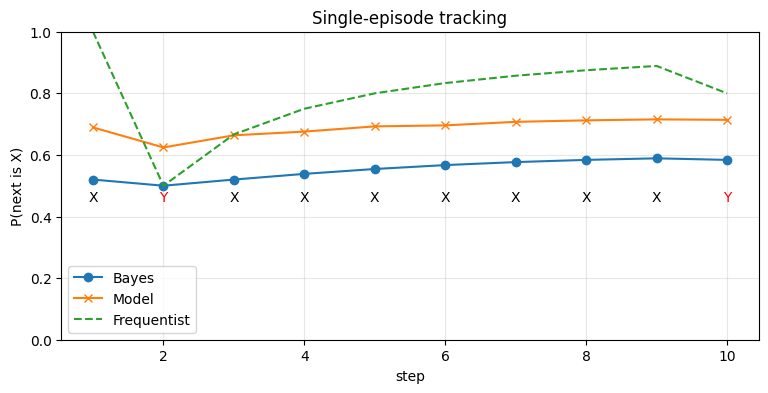

MAE: 0.1357380499757 Bias: 0.1357380499757 Corr: 0.9101440626627955


In [ ]:
# single-episode demo

hidden_urn = 'A' if random.random() < prior_P_A else 'B'
true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX

obs_seq = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_single)]

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
    model_out = get_ab_logprobs(prompt, A_id, B_id)

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])
    bayes_logodds = float(truth.iloc[-1]['bayes_logodds'])
    freq_p = float(truth.iloc[-1]['freq_Phat_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'true_hidden_urn': hidden_urn,
        'bayes_P_next_X': bayes_p,
        'model_P_next_X': model_out['pA_norm'],
        'freq_Phat_X': freq_p,
        'bayes_logodds': bayes_logodds,
        'model_logodds': model_out['logodds_AB'],
    })

single_df = pd.DataFrame(rows)
display(single_df.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(single_df.step, single_df.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(single_df.step, single_df.model_P_next_X, label='Model', marker='x')
ax.plot(single_df.step, single_df.freq_Phat_X, label='Frequentist', linestyle='--')

for i, tok in enumerate(single_df.obs_t):
    ax.annotate(tok, (single_df.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode tracking')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

mae = float((single_df.model_P_next_X - single_df.bayes_P_next_X).abs().mean())
bias = float((single_df.model_P_next_X - single_df.bayes_P_next_X).mean())
corr = float(np.corrcoef(single_df.model_P_next_X, single_df.bayes_P_next_X)[0, 1])
print('MAE:', mae, 'Bias:', bias, 'Corr:', corr)

In [ ]:
# format-bias diagnostics

def readout_AB(prompt):
    out = get_ab_logprobs(prompt, A_id, B_id)
    return out['pA_norm']

def readout_XY(prompt):
    x_id = assert_single_token(' X')
    y_id = assert_single_token(' Y')
    logits = model(prompt)[0, -1, :]
    probs = torch.softmax(logits.float(), dim=-1)
    pX = float(probs[x_id].item())
    pY = float(probs[y_id].item())
    denom = pX + pY
    return pX / denom if denom > 0 else 0.5

balanced_prefix = ['X','Y','X','Y']
empty_prefix = []

# A/B-format prompt for bias checks
def build_prompt_AB(obs_seq):
    seq_str = ' '.join(obs_seq) if len(obs_seq) > 0 else '(none yet)'
    return (
        'There are two urns that produce X or Y. Urn A is biased toward X, and Urn B is biased toward Y.\n'
        f'So far we have seen: {seq_str}.\n'
        'Next is more likely?\n'
        'A) X\n'
        'B) Y\n'
        'Answer:'
    )

# 1) Empty evidence or balanced prefix (A/B format)
prompt_empty = build_prompt_AB(empty_prefix)
prompt_bal = build_prompt_AB(balanced_prefix)
print('p(A|{A,B}) empty:', readout_AB(prompt_empty))
print('p(A|{A,B}) balanced:', readout_AB(prompt_bal))

# 2) Swap option order (A=Y, B=X) but keep same A/B readout
swap_prompt = build_prompt_AB(balanced_prefix)
swap_prompt = swap_prompt.replace('A) X', 'A) Y').replace('B) Y', 'B) X')
print('p(A|{A,B}) with swapped options:', readout_AB(swap_prompt))

# 3) Direct X/Y answer using the main template
xy_prompt = build_prompt(balanced_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
print('p(X|{X,Y}) direct answer:', readout_XY(xy_prompt))

p(A|{A,B}) empty: 0.3830641517108199
p(A|{A,B}) balanced: 0.41679663351319113
p(A|{A,B}) with swapped options: 0.34864515790551837
p(X|{X,Y}) direct answer: 0.6442251267500436


In [ ]:
# batch eval

rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
        model_out = get_ab_logprobs(prompt, A_id, B_id)

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'ep': ep,
            't': t,
            'bayes_P_next_X': bayes_p,
            'model_P_next_X': model_out['pA_norm'],
        })

all_df = pd.DataFrame(rows)

mae = float((all_df.model_P_next_X - all_df.bayes_P_next_X).abs().mean())
bias = float((all_df.model_P_next_X - all_df.bayes_P_next_X).mean())
corr = float(np.corrcoef(all_df.model_P_next_X, all_df.bayes_P_next_X)[0, 1])

summary = pd.DataFrame([{'MAE': mae, 'Bias': bias, 'Corr': corr, 'n': len(all_df)}])
display(summary)
summary.to_csv(os.path.join(output_dir, 'batch_summary_baseline.csv'), index=False)

episodes:   0%|          | 0/300 [00:00<?, ?it/s]

,MAE,Bias,Corr,n
0,0.149454,0.02673,0.700283,3000


In [ ]:
# drift config
drift_counts_total_N = 12
drift_counts_nX = 6
n_permutations = 64

In [ ]:
# martingale drift setup (permutation invariance test)

base_seq = ['X'] * drift_counts_nX + ['Y'] * (drift_counts_total_N - drift_counts_nX)

perm_seqs = []
perm_prompts = []
rng = np.random.default_rng(SEED)

for _ in range(n_permutations):
    seq = base_seq.copy()
    rng.shuffle(seq)
    perm_seqs.append(seq)
    perm_prompts.append(build_prompt(seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version))

preds = []
logit_diffs = []
for prompt in tqdm(perm_prompts, desc='perm eval'):
    out = get_ab_logprobs(prompt, A_id, B_id)
    preds.append(out['pA_norm'])
    logit_diffs.append(out['logit_A'] - out['logit_B'])

perm_df = pd.DataFrame({
    'seq': [' '.join(s) for s in perm_seqs],
    'model_P_next_X': preds,
    'logit_diff_A_minus_B': logit_diffs,
})

prob_series = np.array(perm_df.model_P_next_X)
logit_series = np.array(perm_df.logit_diff_A_minus_B)

def _stats(series):
    return float(np.std(series)), float(series.max() - series.min())

prob_std, prob_range = _stats(prob_series)
logit_std, logit_range = _stats(logit_series)

drift_stats_df = pd.DataFrame([
    {'readout': 'prob', 'std': prob_std, 'max_min': prob_range},
    {'readout': 'logit_diff', 'std': logit_std, 'max_min': logit_range},
])
display(drift_stats_df)

posterior_P_A = bayes_update_posterior(prior_P_A, urn_A_pX, urn_B_pX, base_seq)
bayes_pred = bayes_predictive(posterior_P_A, urn_A_pX, urn_B_pX)
bayes_logodds = logodds(bayes_pred)
print('Bayes predictive P(next=X):', bayes_pred)
print('Bayes predictive log-odds (logit):', bayes_logodds)

perm_df_sorted = perm_df.sort_values('model_P_next_X')
print('Lowest predictions:')
display(perm_df_sorted.head(3))
print('Highest predictions:')
display(perm_df_sorted.tail(3))

perm eval:   0%|          | 0/64 [00:00<?, ?it/s]

,readout,std,max_min
0,prob,0.171221,0.551602
1,logit_diff,0.743405,2.484375


Bayes predictive P(next=X): 0.5
Bayes predictive log-odds (logit): 0.0
Lowest predictions:


,seq,model_P_next_X,logit_diff_A_minus_B
29,Y Y Y Y Y Y X X X X X X,0.233706,-1.187500
13,Y Y Y X Y X Y Y X X X X,0.255344,-1.070312
30,Y Y Y X Y X X X X Y Y X,0.259826,-1.046875


Highest predictions:


,seq,model_P_next_X,logit_diff_A_minus_B
51,X X X X Y X Y Y Y Y X Y,0.783988,1.289062
23,X X X X Y X Y Y Y X Y Y,0.783988,1.289062
32,X X X X Y X Y X Y Y Y Y,0.785309,1.296875


In [ ]:
# head ablation utilities
from collections import defaultdict

def make_head_ablation_hooks(head_indices, mode='zero', scale=0.0):
    # head_indices: list of (layer, head) pairs
    # We ablate at hook_z (per-head output before mixing), matching toy_induction.
    layer_to_heads = defaultdict(list)
    for layer, head in head_indices:
        layer_to_heads[int(layer)].append(int(head))

    hooks = []
    for layer, heads in layer_to_heads.items():
        heads = sorted(set(heads))
        hook_name = get_act_name('z', layer)

        def hook_fn(act, hook, heads=heads, mode=mode, scale=scale):
            # act: [batch, pos, head, d_head]
            if mode == 'zero':
                act[:, :, heads, :] = 0.0
            elif mode == 'scale':
                act[:, :, heads, :] = act[:, :, heads, :] * scale
            else:
                raise ValueError('Unknown mode')
            return act

        hooks.append((hook_name, hook_fn))
    return hooks

@torch.no_grad()
def get_pA_for_prompts_batch(prompts, hooks=None):
    tokens = model.to_tokens(prompts, prepend_bos=True)
    logits = model(tokens) if hooks is None else model.run_with_hooks(tokens, fwd_hooks=hooks)
    last = logits[:, -1, :]
    probs = torch.softmax(last.float(), dim=-1)

    pA = probs[:, A_id]
    pB = probs[:, B_id]
    denom = pA + pB
    pA_norm = pA / denom
    return pA_norm.detach().cpu().numpy()

@torch.no_grad()
def get_logitdiff_for_prompts_batch(prompts, hooks=None):
    tokens = model.to_tokens(prompts, prepend_bos=True)
    logits = model(tokens) if hooks is None else model.run_with_hooks(tokens, fwd_hooks=hooks)
    last = logits[:, -1, :]
    logit_diff = (last[:, A_id] - last[:, B_id]).detach().cpu().numpy()
    return logit_diff

def run_model_with_optional_ablation(prompts, heads_to_ablate):
    if heads_to_ablate is None or len(heads_to_ablate) == 0:
        return get_pA_for_prompts_batch(prompts, hooks=None)
    hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
    return get_pA_for_prompts_batch(prompts, hooks=hooks)

def drift_stats_from_prompts(prompts, hooks=None):
    pA = get_pA_for_prompts_batch(prompts, hooks=hooks)
    logit = get_logitdiff_for_prompts_batch(prompts, hooks=hooks)
    def _stats(arr):
        return float(np.std(arr)), float(arr.max() - arr.min())
    prob_std, prob_range = _stats(pA)
    logit_std, logit_range = _stats(logit)
    return {
        'prob_std': prob_std,
        'prob_max_min': prob_range,
        'logit_diff_std': logit_std,
        'logit_diff_max_min': logit_range,
    }

In [ ]:
# head search config
# head_search_scope: 'all' scans every layer, 'layers_subset' only scans layers_subset
# layers_subset ignored unless head_search_scope == 'layers_subset'
head_search_scope = "all"
layers_subset = list(range(0, 4))
# how many heads to display in the ranked table
top_k_heads_to_report = 30
# ranking metric (we still compute all drift stats; this only chooses sort order)
head_rank_readout = 'logit_diff'  # 'prob' or 'logit_diff'
head_rank_metric = 'std'  # 'std' or 'max_min'

In [ ]:
# identify drift-driving heads by ablation scan

baseline_preds = get_pA_for_prompts_batch(perm_prompts)
baseline_logits = get_logitdiff_for_prompts_batch(perm_prompts)

base_stats = drift_stats_from_prompts(perm_prompts, hooks=None)
print('Baseline drift stats:', base_stats)

if head_search_scope == 'all':
    candidate_layers = list(range(model.cfg.n_layers))
else:
    candidate_layers = list(layers_subset)

rows = []
for layer in tqdm(candidate_layers, desc='layer scan'):
    for head in range(model.cfg.n_heads):
        hooks = make_head_ablation_hooks([(layer, head)], mode='zero')
        preds = get_pA_for_prompts_batch(perm_prompts, hooks=hooks)
        logits = get_logitdiff_for_prompts_batch(perm_prompts, hooks=hooks)
        prob_std = float(np.std(preds))
        prob_range = float(preds.max() - preds.min())
        logit_std = float(np.std(logits))
        logit_range = float(logits.max() - logits.min())
        stats = {
            'prob_std': prob_std,
            'prob_max_min': prob_range,
            'logit_diff_std': logit_std,
            'logit_diff_max_min': logit_range,
        }
        key = f"{head_rank_readout}_{head_rank_metric}"
        drift_reduction_primary = base_stats[key] - stats[key]
        rows.append({
            'layer': layer,
            'head': head,
            'drift_reduction_primary': drift_reduction_primary,
            'drift_baseline_primary': base_stats[key],
            'drift_ablated_primary': stats[key],
            'mean_P_next_X_baseline': float(baseline_preds.mean()),
            'mean_P_next_X_ablated': float(preds.mean()),
            **stats,
        })

head_rank = pd.DataFrame(rows).sort_values('drift_reduction_primary', ascending=False)

print('Ranking by', head_rank_readout, head_rank_metric)
display(head_rank.head(top_k_heads_to_report))

head_rank.to_csv(os.path.join(output_dir, 'head_drift_ranking.csv'), index=False)

Baseline drift stats: {'prob_std': 0.1712205857038498, 'prob_max_min': 0.5516022443771362, 'logit_diff_std': 0.74365234375, 'logit_diff_max_min': 2.484375}


layer scan:   0%|          | 0/3 [00:00<?, ?it/s]

Ranking by logit_diff std


,layer,head,drift_reduction_primary,drift_baseline_primary,drift_ablated_primary,mean_P_next_X_baseline,mean_P_next_X_ablated,prob_std,prob_max_min,logit_diff_std,logit_diff_max_min
6,0,6,0.642944,0.743652,0.100708,0.554666,0.459647,0.024879,0.098155,0.100708,0.398438
0,0,0,0.590454,0.743652,0.153198,0.554666,0.466029,0.037911,0.144623,0.153198,0.585938
4,0,4,0.481201,0.743652,0.262451,0.554666,0.290493,0.051585,0.210113,0.262451,1.109375
18,2,2,0.332275,0.743652,0.411377,0.554666,0.566367,0.099396,0.334305,0.411377,1.398438
14,1,6,0.289795,0.743652,0.453857,0.554666,0.433306,0.106982,0.343804,0.453857,1.484375
19,2,3,0.265381,0.743652,0.478271,0.554666,0.372825,0.106750,0.335615,0.478271,1.539062
1,0,1,0.257568,0.743652,0.486084,0.554666,0.394496,0.109982,0.359695,0.486084,1.625000
12,1,4,0.230469,0.743652,0.513184,0.554666,0.382031,0.112675,0.397162,0.513184,1.859375
13,1,5,0.202637,0.743652,0.541016,0.554666,0.528032,0.129214,0.438701,0.541016,1.882812
15,1,7,0.185059,0.743652,0.558594,0.554666,0.643687,0.124403,0.483370,0.558594,2.210938


In [ ]:
# ablation config
# use_manual_heads: if True, use heads_to_ablate_manual instead of top-K from head_rank
use_manual_heads = False
heads_to_ablate_manual = [(0, 6)]  # e.g., [(0, 0), (1, 3)]
# how many top heads from head_rank to ablate when not using manual list
top_k_heads_to_ablate_default = 5
# ablation mode
ablate_mode = 'zero'  # 'zero' or 'scale'
ablate_scale = 0.0

In [ ]:
# choose heads to ablate

if use_manual_heads and len(heads_to_ablate_manual) > 0:
    heads_to_ablate = list(heads_to_ablate_manual)
else:
    heads_to_ablate = [(int(r.layer), int(r.head)) for r in head_rank.head(top_k_heads_to_ablate_default).itertuples()]

print('heads_to_ablate:', heads_to_ablate)

heads_to_ablate: [(0, 6), (0, 0), (0, 4), (2, 2), (1, 6)]


,step,obs_t,bayes_P_next_X,model_P_next_X_base,model_P_next_X_ablated,freq_Phat_X
0,1,X,0.520000,0.689306,0.472683,1.000000
1,2,X,0.538462,0.740174,0.461017,1.000000
2,3,Y,0.520000,0.731059,0.449393,0.666667
3,4,X,0.538462,0.743168,0.447460,0.750000
4,5,Y,0.520000,0.743168,0.432063,0.600000


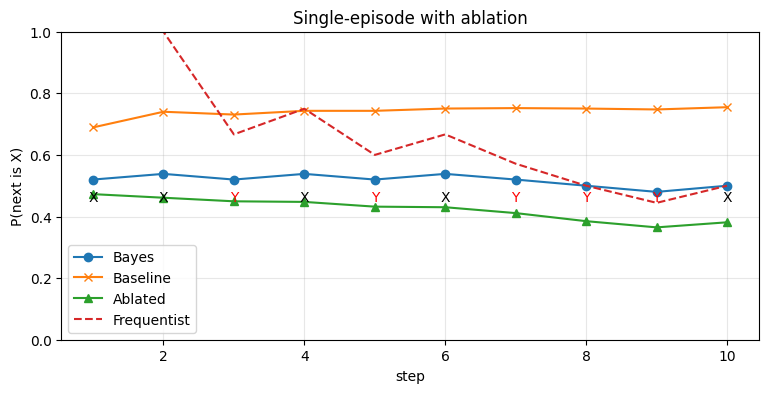

Baseline MAE: 0.22271389111337098 Bias: 0.22271389111337098
Ablated MAE: 0.09406005269054077 Bias: -0.09406005269054077


In [ ]:
# single-episode demo with ablation (baseline vs ablated vs Bayes)

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

    base = get_ab_logprobs(prompt, A_id, B_id)
    abl = None
    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
        last = logits[0, -1, :]
        probs = torch.softmax(last.float(), dim=-1)
        pA = float(probs[A_id].item())
        pB = float(probs[B_id].item())
        abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])
    freq_p = float(truth.iloc[-1]['freq_Phat_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'bayes_P_next_X': bayes_p,
        'model_P_next_X_base': base['pA_norm'],
        'model_P_next_X_ablated': abl,
        'freq_Phat_X': freq_p,
    })

abl_df = pd.DataFrame(rows)
display(abl_df.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(abl_df.step, abl_df.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(abl_df.step, abl_df.model_P_next_X_base, label='Baseline', marker='x')
if heads_to_ablate:
    ax.plot(abl_df.step, abl_df.model_P_next_X_ablated, label='Ablated', marker='^')
ax.plot(abl_df.step, abl_df.freq_Phat_X, label='Frequentist', linestyle='--')

for i, tok in enumerate(abl_df.obs_t):
    ax.annotate(tok, (abl_df.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode with ablation')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

mae_base = float((abl_df.model_P_next_X_base - abl_df.bayes_P_next_X).abs().mean())
bias_base = float((abl_df.model_P_next_X_base - abl_df.bayes_P_next_X).mean())

print('Baseline MAE:', mae_base, 'Bias:', bias_base)
if heads_to_ablate:
    mae_abl = float((abl_df.model_P_next_X_ablated - abl_df.bayes_P_next_X).abs().mean())
    bias_abl = float((abl_df.model_P_next_X_ablated - abl_df.bayes_P_next_X).mean())
    print('Ablated MAE:', mae_abl, 'Bias:', bias_abl)

In [ ]:
# batch evaluation with ablation (baseline vs ablated)

rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq_batch = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq_batch[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
        base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']

        abl = None
        if heads_to_ablate:
            hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
            logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
            last = logits[0, -1, :]
            probs = torch.softmax(last.float(), dim=-1)
            pA = float(probs[A_id].item())
            pB = float(probs[B_id].item())
            abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'bayes_P_next_X': bayes_p,
            'model_P_next_X_base': base,
            'model_P_next_X_ablated': abl,
        })

all_df2 = pd.DataFrame(rows)

summary_rows = []
mae_base = float((all_df2.model_P_next_X_base - all_df2.bayes_P_next_X).abs().mean())
bias_base = float((all_df2.model_P_next_X_base - all_df2.bayes_P_next_X).mean())
corr_base = float(np.corrcoef(all_df2.model_P_next_X_base, all_df2.bayes_P_next_X)[0, 1])
summary_rows.append({'model': 'baseline', 'MAE': mae_base, 'Bias': bias_base, 'Corr': corr_base})

if heads_to_ablate:
    mae_abl = float((all_df2.model_P_next_X_ablated - all_df2.bayes_P_next_X).abs().mean())
    bias_abl = float((all_df2.model_P_next_X_ablated - all_df2.bayes_P_next_X).mean())
    corr_abl = float(np.corrcoef(all_df2.model_P_next_X_ablated, all_df2.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': 'ablated', 'MAE': mae_abl, 'Bias': bias_abl, 'Corr': corr_abl})

summary = pd.DataFrame(summary_rows)
display(summary)

base_stats = drift_stats_from_prompts(perm_prompts, hooks=None)
print('Baseline drift stats:', base_stats)

if heads_to_ablate:
    hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
    ablated_stats = drift_stats_from_prompts(perm_prompts, hooks=hooks)
    print('Ablated drift stats:', ablated_stats)
    rows_stats = []
    for key in base_stats:
        rows_stats.append({
            'metric': key,
            'baseline': base_stats[key],
            'ablated': ablated_stats[key],
            'reduction': base_stats[key] - ablated_stats[key],
        })
    display(pd.DataFrame(rows_stats))

summary.to_csv(os.path.join(output_dir, 'batch_summary_ablation.csv'), index=False)

episodes:   0%|          | 0/300 [00:00<?, ?it/s]

,model,MAE,Bias,Corr
0,baseline,0.145047,0.041117,0.686808
1,ablated,0.073442,-0.073381,0.241556


Baseline drift stats: {'prob_std': 0.1712205857038498, 'prob_max_min': 0.5516022443771362, 'logit_diff_std': 0.74365234375, 'logit_diff_max_min': 2.484375}
Ablated drift stats: {'prob_std': 0.022311601787805557, 'prob_max_min': 0.09921100735664368, 'logit_diff_std': 0.0947265625, 'logit_diff_max_min': 0.421875}


,metric,baseline,ablated,reduction
0,prob_std,0.171221,0.022312,0.148909
1,prob_max_min,0.551602,0.099211,0.452391
2,logit_diff_std,0.743652,0.094727,0.648926
3,logit_diff_max_min,2.484375,0.421875,2.062500


In [ ]:
# circuitVis attention visualization (baseline and ablated)

min_seq = perm_df_sorted.head(1).iloc[0]['seq'].split(' ')
max_seq = perm_df_sorted.tail(1).iloc[0]['seq'].split(' ')

for label, seq in [('min', min_seq), ('max', max_seq)]:
    prompt = build_prompt(seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
    print('===', label, 'prompt ===')
    print(prompt)
    logits, cache = model.run_with_cache(prompt)
    tokens = model.to_str_tokens(prompt)
    for layer in range(model.cfg.n_layers):
        patt = cache['pattern', layer][0].detach().cpu().numpy()
        display(cv.attention.attention_patterns(tokens=tokens, attention=patt))

    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits2, cache2 = model.run_with_cache(prompt, fwd_hooks=hooks)
        for layer in range(model.cfg.n_layers):
            patt2 = cache2['pattern', layer][0].detach().cpu().numpy()
            display(cv.attention.attention_patterns(tokens=tokens, attention=patt2, title=f'{label}: layer {layer} (ablated)'))

=== min prompt ===
Two urns produce X/Y. Urn A produces X about 60% of the time, Urn B produces X about 40% of the time.
Observed sequence: Y Y Y Y Y Y X X X X X X.
Which is more likely next? Answer with X or Y:


TypeError: HookedTransformer.forward() got an unexpected keyword argument 'fwd_hooks'

In [202]:
# probe config
probe_act_name = 'resid_post'  # 'resid_post' or 'resid_pre'
probe_position = 'answer_pos'  # last position
probe_train_size = 200
probe_type = "ridge"  # ridge recommended
# memory control: smaller batch reduces VRAM, per_layer caches only one layer at a time
probe_batch_size = 8
probe_cache_mode = 'per_layer'  # 'per_layer' or 'all_layers'


In [ ]:
# probe dataset helpers

from collections import defaultdict
from sklearn.linear_model import Ridge

def generate_episode(pA, pB, prior, length):
    hidden = 'A' if random.random() < prior else 'B'
    pX = pA if hidden == 'A' else pB
    obs = ['X' if random.random() < pX else 'Y' for _ in range(length)]
    return hidden, obs

def get_target_logodds(obs_prefix, target):
    pA = bayes_update_posterior(prior_P_A, urn_A_pX, urn_B_pX, obs_prefix)
    if target == 'posterior_logodds':
        return logodds(pA)
    if target == 'predictive_logodds':
        p_next = bayes_predictive(pA, urn_A_pX, urn_B_pX)
        return logodds(p_next)
    raise ValueError('Unknown probe target')

def batch_by_length(prompts):
    groups = defaultdict(list)
    for i, p in enumerate(prompts):
        length = len(model.tokenizer.encode(p, add_special_tokens=False)) + 1
        groups[length].append(i)
    return groups

def _chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

def build_probe_dataset(target, n_episodes, seq_len):
    prompts = []
    labels = []
    for _ in range(n_episodes):
        _, obs = generate_episode(urn_A_pX, urn_B_pX, prior_P_A, seq_len)
        for t in range(1, seq_len + 1):
            prefix = obs[:t]
            prompts.append(build_prompt(prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version))
            labels.append(get_target_logodds(prefix, target))
    labels = np.array(labels, dtype=np.float32)

    X_by_layer = {layer: [] for layer in range(model.cfg.n_layers)}
    idx_groups = batch_by_length(prompts)

    with torch.no_grad():
        for length, idxs in tqdm(idx_groups.items(), desc=f'probe extract ({target})'):
            for chunk in _chunks(idxs, probe_batch_size):
                batch_prompts = [prompts[i] for i in chunk]
                tokens = model.to_tokens(batch_prompts, prepend_bos=True)

                if probe_cache_mode == 'all_layers':
                    names = [get_act_name(probe_act_name, layer) for layer in range(model.cfg.n_layers)]
                    _, cache = model.run_with_cache(tokens, names_filter=names)
                    for layer in range(model.cfg.n_layers):
                        act = cache[probe_act_name, layer][:, -1, :].detach().cpu().numpy()
                        X_by_layer[layer].append(act)
                    del cache
                else:
                    for layer in range(model.cfg.n_layers):
                        name = get_act_name(probe_act_name, layer)
                        _, cache = model.run_with_cache(tokens, names_filter=[name], stop_at_layer=layer + 1)
                        act = cache[probe_act_name, layer][:, -1, :].detach().cpu().numpy()
                        X_by_layer[layer].append(act)
                        del cache

                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

    for layer in X_by_layer:
        X_by_layer[layer] = np.concatenate(X_by_layer[layer], axis=0)

    print('Probe dataset shape example:', X_by_layer[0].shape, 'labels:', labels.shape)
    return prompts, labels, X_by_layer

def train_probes_all_layers(X_by_layer, labels, tag):
    results = []
    probe_weights = {}

    n_total = len(labels)
    idx = np.arange(n_total)
    np.random.shuffle(idx)
    split = int(0.8 * n_total)
    train_idx, test_idx = idx[:split], idx[split:]

    for layer in tqdm(range(model.cfg.n_layers), desc=f'probe train ({tag})'):
        X = X_by_layer[layer]
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = labels[train_idx], labels[test_idx]

        if probe_type == 'ridge':
            reg = Ridge(alpha=1.0, fit_intercept=True)
            reg.fit(X_tr, y_tr)
            w = reg.coef_
            b = float(reg.intercept_)
        else:
            raise ValueError('Only ridge implemented in this notebook')

        pred = X_te @ w + b
        pred_p = 1 / (1 + np.exp(-pred))
        true_p = 1 / (1 + np.exp(-y_te))

        mae = float(np.mean(np.abs(pred_p - true_p)))
        mse = float(np.mean((pred - y_te) ** 2))
        corr = float(np.corrcoef(pred_p, true_p)[0, 1])

        results.append({'layer': layer, 'MAE': mae, 'MSE_logodds': mse, 'Corr': corr})
        probe_weights[layer] = (w, b)

        np.save(os.path.join(output_dir, f'probe_w_layer{layer}_{tag}.npy'), w.astype(np.float32))
        np.save(os.path.join(output_dir, f'probe_b_layer{layer}_{tag}.npy'), np.array([b], dtype=np.float32))

    res_df = pd.DataFrame(results).sort_values('MAE')
    display(res_df.head(10))
    res_df.to_csv(os.path.join(output_dir, f'probe_results_{tag}.csv'), index=False)
    return res_df, probe_weights


In [204]:
# train probes: posterior logodds
probe_target = 'posterior_logodds'
_, labels_post, X_by_layer_post = build_probe_dataset(probe_target, probe_train_size, seq_len_batch)
res_df_posterior, probe_weights_posterior = train_probes_all_layers(X_by_layer_post, labels_post, tag='posterior')


probe extract (posterior_logodds):   0%|          | 0/10 [00:00<?, ?it/s]

Probe dataset shape example: (2000, 512) labels: (2000,)


probe train (posterior):   0%|          | 0/3 [00:00<?, ?it/s]

,layer,MAE,MSE_logodds,Corr
1,1,0.166198,0.986294,0.184603
2,2,0.166511,0.987767,0.174637
0,0,0.167084,0.990293,0.180352


In [205]:
# train probes: predictive logodds
probe_target = 'predictive_logodds'
_, labels_pred, X_by_layer_pred = build_probe_dataset(probe_target, probe_train_size, seq_len_batch)
res_df_predictive, probe_weights_predictive = train_probes_all_layers(X_by_layer_pred, labels_pred, tag='predictive')


probe extract (predictive_logodds):   0%|          | 0/10 [00:00<?, ?it/s]

Probe dataset shape example: (2000, 512) labels: (2000,)


probe train (predictive):   0%|          | 0/3 [00:00<?, ?it/s]

,layer,MAE,MSE_logodds,Corr
0,0,0.034014,0.027823,0.155001
1,1,0.034052,0.027693,0.159042
2,2,0.034201,0.027942,0.125552


,step,obs_t,bayes_P_next_X,baseline_P_next_X,ablated_P_next_X,probe_P_next_X
0,1,X,0.520000,0.689306,0.472683,0.452002
1,2,X,0.538462,0.740174,0.461017,0.429659
2,3,Y,0.520000,0.731059,0.449393,0.492615
3,4,X,0.538462,0.743168,0.447460,0.444644
4,5,Y,0.520000,0.743168,0.432063,0.459913


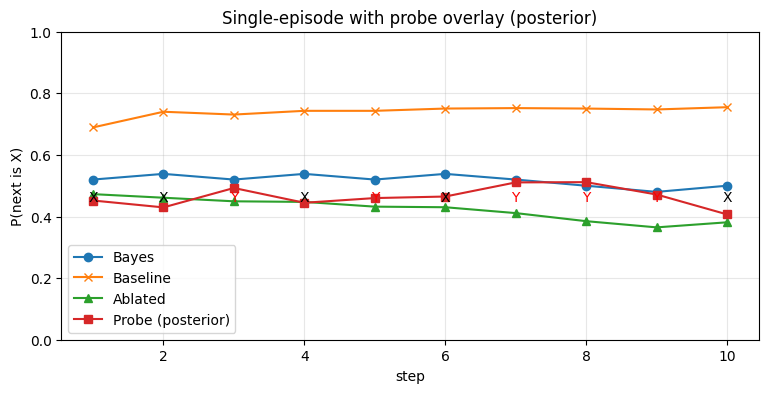

baseline_P_next_X MAE 0.22271389111337098 Bias 0.22271389111337098
probe_P_next_X MAE 0.05541393435207387 Bias -0.05309347864502565


In [206]:
# probe overlay (posterior)
posterior_probe_layer = int(res_df_posterior.iloc[0]['layer'])
w_post, b_post = probe_weights_posterior[posterior_probe_layer]

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

    base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
    abl = None
    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
        last = logits[0, -1, :]
        probs = torch.softmax(last.float(), dim=-1)
        pA = float(probs[A_id].item())
        pB = float(probs[B_id].item())
        abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

    tokens = model.to_tokens(prompt, prepend_bos=True)
    logits, cache = model.run_with_cache(tokens)
    act = cache[probe_act_name, posterior_probe_layer][0, -1, :].detach().cpu().numpy()
    pred_logodds = act @ w_post + b_post
    probe_p = 1 / (1 + np.exp(-pred_logodds))

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'bayes_P_next_X': bayes_p,
        'baseline_P_next_X': base,
        'ablated_P_next_X': abl,
        'probe_P_next_X': float(probe_p),
    })

probe_df_post = pd.DataFrame(rows)
display(probe_df_post.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(probe_df_post.step, probe_df_post.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(probe_df_post.step, probe_df_post.baseline_P_next_X, label='Baseline', marker='x')
if heads_to_ablate:
    ax.plot(probe_df_post.step, probe_df_post.ablated_P_next_X, label='Ablated', marker='^')
ax.plot(probe_df_post.step, probe_df_post.probe_P_next_X, label='Probe (posterior)', marker='s')

for i, tok in enumerate(probe_df_post.obs_t):
    ax.annotate(tok, (probe_df_post.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode with probe overlay (posterior)')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

for name in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((probe_df_post[name] - probe_df_post.bayes_P_next_X).abs().mean())
    bias = float((probe_df_post[name] - probe_df_post.bayes_P_next_X).mean())
    print(name, 'MAE', mae, 'Bias', bias)


,step,obs_t,bayes_P_next_X,baseline_P_next_X,ablated_P_next_X,probe_P_next_X
0,1,X,0.520000,0.689306,0.472683,0.500961
1,2,X,0.538462,0.740174,0.461017,0.500670
2,3,Y,0.520000,0.731059,0.449393,0.507069
3,4,X,0.538462,0.743168,0.447460,0.499120
4,5,Y,0.520000,0.743168,0.432063,0.506165


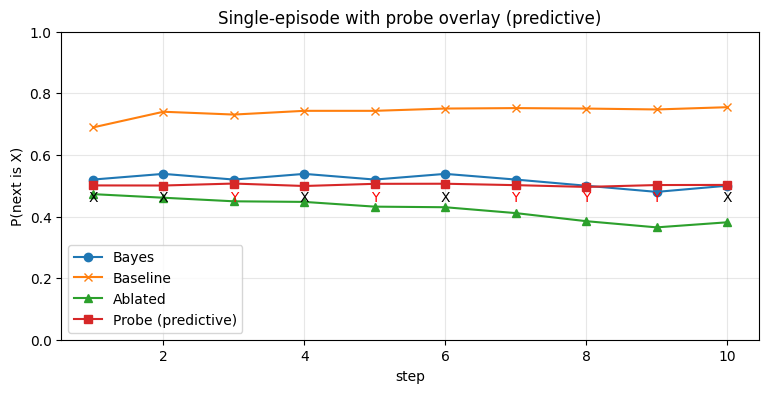

baseline_P_next_X MAE 0.22271389111337098 Bias 0.22271389111337098
probe_P_next_X MAE 0.020175862832184765 Bias -0.015211711088171376


In [207]:
# probe overlay (predictive)
predictive_probe_layer = int(res_df_predictive.iloc[0]['layer'])
w_pred, b_pred = probe_weights_predictive[predictive_probe_layer]

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

    base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
    abl = None
    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
        last = logits[0, -1, :]
        probs = torch.softmax(last.float(), dim=-1)
        pA = float(probs[A_id].item())
        pB = float(probs[B_id].item())
        abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

    tokens = model.to_tokens(prompt, prepend_bos=True)
    logits, cache = model.run_with_cache(tokens)
    act = cache[probe_act_name, predictive_probe_layer][0, -1, :].detach().cpu().numpy()
    pred_logodds = act @ w_pred + b_pred
    probe_p = 1 / (1 + np.exp(-pred_logodds))

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'bayes_P_next_X': bayes_p,
        'baseline_P_next_X': base,
        'ablated_P_next_X': abl,
        'probe_P_next_X': float(probe_p),
    })

probe_df_pred = pd.DataFrame(rows)
display(probe_df_pred.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(probe_df_pred.step, probe_df_pred.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(probe_df_pred.step, probe_df_pred.baseline_P_next_X, label='Baseline', marker='x')
if heads_to_ablate:
    ax.plot(probe_df_pred.step, probe_df_pred.ablated_P_next_X, label='Ablated', marker='^')
ax.plot(probe_df_pred.step, probe_df_pred.probe_P_next_X, label='Probe (predictive)', marker='s')

for i, tok in enumerate(probe_df_pred.obs_t):
    ax.annotate(tok, (probe_df_pred.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode with probe overlay (predictive)')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

for name in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((probe_df_pred[name] - probe_df_pred.bayes_P_next_X).abs().mean())
    bias = float((probe_df_pred[name] - probe_df_pred.bayes_P_next_X).mean())
    print(name, 'MAE', mae, 'Bias', bias)


In [208]:
# batch evaluation with probe (posterior)
rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq_batch = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq_batch[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

        base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
        abl = None
        if heads_to_ablate:
            hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
            logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
            last = logits[0, -1, :]
            probs = torch.softmax(last.float(), dim=-1)
            pA = float(probs[A_id].item())
            pB = float(probs[B_id].item())
            abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

        tokens = model.to_tokens(prompt, prepend_bos=True)
        logits, cache = model.run_with_cache(tokens)
        act = cache[probe_act_name, posterior_probe_layer][0, -1, :].detach().cpu().numpy()
        pred_logodds = act @ w_post + b_post
        probe_p = 1 / (1 + np.exp(-pred_logodds))

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'bayes_P_next_X': bayes_p,
            'baseline_P_next_X': base,
            'ablated_P_next_X': abl,
            'probe_P_next_X': float(probe_p),
        })

all_df_post = pd.DataFrame(rows)

summary_rows = []
for col in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((all_df_post[col] - all_df_post.bayes_P_next_X).abs().mean())
    bias = float((all_df_post[col] - all_df_post.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df_post[col], all_df_post.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

if heads_to_ablate:
    col = 'ablated_P_next_X'
    mae = float((all_df_post[col] - all_df_post.bayes_P_next_X).abs().mean())
    bias = float((all_df_post[col] - all_df_post.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df_post[col], all_df_post.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

summary_post = pd.DataFrame(summary_rows)
display(summary_post)
summary_post.to_csv(os.path.join(output_dir, 'batch_summary_with_probe_posterior.csv'), index=False)


episodes:   0%|          | 0/300 [00:00<?, ?it/s]

,model,MAE,Bias,Corr
0,baseline_P_next_X,0.143560,0.029677,0.650009
1,probe_P_next_X,0.049619,-0.026860,-0.046584
2,ablated_P_next_X,0.069502,-0.069434,0.215397


In [209]:
# batch evaluation with probe (predictive)
rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq_batch = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq_batch[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

        base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
        abl = None
        if heads_to_ablate:
            hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
            logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
            last = logits[0, -1, :]
            probs = torch.softmax(last.float(), dim=-1)
            pA = float(probs[A_id].item())
            pB = float(probs[B_id].item())
            abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

        tokens = model.to_tokens(prompt, prepend_bos=True)
        logits, cache = model.run_with_cache(tokens)
        act = cache[probe_act_name, predictive_probe_layer][0, -1, :].detach().cpu().numpy()
        pred_logodds = act @ w_pred + b_pred
        probe_p = 1 / (1 + np.exp(-pred_logodds))

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'bayes_P_next_X': bayes_p,
            'baseline_P_next_X': base,
            'ablated_P_next_X': abl,
            'probe_P_next_X': float(probe_p),
        })

all_df_pred = pd.DataFrame(rows)

summary_rows = []
for col in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((all_df_pred[col] - all_df_pred.bayes_P_next_X).abs().mean())
    bias = float((all_df_pred[col] - all_df_pred.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df_pred[col], all_df_pred.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

if heads_to_ablate:
    col = 'ablated_P_next_X'
    mae = float((all_df_pred[col] - all_df_pred.bayes_P_next_X).abs().mean())
    bias = float((all_df_pred[col] - all_df_pred.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df_pred[col], all_df_pred.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

summary_pred = pd.DataFrame(summary_rows)
display(summary_pred)
summary_pred.to_csv(os.path.join(output_dir, 'batch_summary_with_probe_predictive.csv'), index=False)


episodes:   0%|          | 0/300 [00:00<?, ?it/s]

,model,MAE,Bias,Corr
0,baseline_P_next_X,0.142097,0.044082,0.655492
1,probe_P_next_X,0.034967,0.000876,-0.390636
2,ablated_P_next_X,0.072372,-0.072330,0.244784
